# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

# Importando as bibliotecas

In [14]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc
import pandasql as ps

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [15]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

# Importa pacotes do sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA, FastICA, TruncatedSVD


# Carregando os dados de treino e teste

In [16]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [17]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


# Feature Engineering

In [18]:
# Juntando os datasets de treino e teste para realizar todos os tratamentos nos dados
df = train.append(test)

In [19]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
        
        
# Realizando tratamento de missing value
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c].fillna(df[c].mean(),inplace=True)


In [20]:
# Criando novas features atraces do PCA / ICA / GRP e SRP

n_comp = 4

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=42)
tsvd_results_df = tsvd.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_df = pca.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_df = ica.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_df = grp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_df = srp.fit_transform(df.drop(columns = ['ID','target'], axis = 1))


# Append dos componentes com o dataset
for i in range(1, n_comp+1):
    df['pca_' + str(i)]  = pca2_results_df[:,i-1]
    df['ica_' + str(i)]  = ica2_results_df[:,i-1]
    df['tsvd_' + str(i)] = tsvd_results_df[:,i-1]
    df['grp_' + str(i)]  = grp_results_df[:,i-1]
    df['srp_' + str(i)]  = srp_results_df[:,i-1] 

In [21]:
# Patronizacao dos dados
scaler = StandardScaler()
for c in df.columns:
    if c != 'ID' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [22]:
df.head()

,ID,target,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v12,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v13,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v3,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v4,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v5,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v6,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v7,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v8,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v9,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,pca_1,ica_1,tsvd_1,grp_1,srp_1,pca_2,ica_2,tsvd_2,grp_2,srp_2,pca_3,ica_3,tsvd_3,grp_3,srp_3,pca_4,ica_4,tsvd_4,grp_4,srp_4
0,3,1.0,-3.630884e-01,-0.988587,1.426492e+00,8.664723e-01,-9.985041e-02,-9.993504e-01,-1.603550e+00,-6.321401e-01,3.597110e-01,1.182075,3.363053e-01,-8.765501e-02,1.667904e+00,0.831485,-2.622701e+00,0.883153,0.844842,0.788076,-5.395886e+00,-6.744603e-01,-6.212775e-01,-1.628388e+00,-1.002128e+00,-0.860860,-4.218365e-01,-1.897890e+00,8.740917e-01,-8.049388e-01,-5.557083e-01,-0.971775,3.479667e-01,-1.025077e-01,-6.394812e-03,-0.447656,-1.055068e+00,-1.357901e+00,1.313722e+00,-0.318839,-1.320749e+00,2.718014e+00,-1.088830e-01,-1.523347e+00,-6.007835e-01,5.758824e-01,1.262254e+00,0.655297,1.407234,-3.665499e-01,-0.947545,-6.977245e-01,-3.713495e-01,1.045534e+00,-2.233208e+00,6.972928e-01,-0.134466,-1.310776,-0.468331,-1.271144e+00,-1.555671e+00,0.426663,2.527878e-01,-1.142042e+00,-7.136852e-01,-0.15536,1.549473e+00,-2.574366e-01,-0.869074,6.226219e-01,-2.945532e-01,-4.115180e-01,-1.838857e-01,4.581655e-01,-6.931760e-01,-0.926604,-2.261067e-01,1.007197e-01,-5.330178e-01,-0.519972,4.165406e-02,0.127292,1.730589e+00,-6.953976e-01,-4.170095e-01,0.564731,-2.097269e-01,-1.396141e+00,1.977376e-01,3.660054e-01,-3.086479e-01,8.031786e-01,-0.044084,-6.836550e-01,1.464511e-02,1.740320e+00,1.676532,2.978146e-02,-1.340124e+00,5.394183e+00,1.563350e+00,-2.760003e-01,0.713931,-0.466302,-1.366136e+00,-0.071457,0.721636,-1.639394e-01,-1.613851e-02,-3.445916e+00,-0.007392,-7.042218e-01,9.827842e-01,1.430320e-01,9.460638e-01,-1.908728e+00,-4.379935e-01,-1.050689e+00,-1.006735e+00,-0.274443,1.776152e+00,-6.707387e-01,6.690789e-01,-4.153842e-01,-1.120052,-7.102480e-01,2.788122e-01,-5.231948e-01,-9.519235e-01,1.162310e+00,-1.495501e+00,6.861507e-01,-1.679475e-01,-1.407234,-0.825555,1.407240,-1.408983,0.522212,-0.523785,0.968736,-1.089817,1.407897,1.174206,0.929380,-1.384258,-1.180599,1.409779,-1.915372,-1.068187,0.850453,0.423371,-1.468680,-1.579103
1,4,1.0,7.954795e-15,-0.408365,6.176752e-15,-7.046277e-15,5.888360e-15,-1.245498e-14,1.063419e-14,2.466274e-01,-8.817948e-15,-0.944226,-4.703689e-01,2.486966e-02,-2.071239e-13,-0.980198,-8.332144e-15,1.895383,-0.837254,-1.248775,-8.724587e-15,1.500754e-14,8.369273e-01,4.710601e-15,2.104422e-15,-0.403811,-1.480779e-14,-3.915604e-15,-4.748429e-14,-2.468963e-14,-2.054999e-01,-1.562332,2.878056e-14,7.283738e-16,-8.815310e-02,-0.447656,6.349561e-14,-3.731841e-15,-1.433347e-14,-0.318840,5.161091e-14,-1.983033e-15,1.391286e-14,1.673773e-14,-9.962328e-15,8.810249e-15,-2.861879e-14,-0.254933,-0.285476,-1.487179e-16,-0.947545,6.045598e-01,7.989758e-15,-2.134595e-15,-7.038195e-15,-3.675856e-14,-0.134466,-1.310776,-0.468331,-3.238515e-14,1.078469e-14,-1.377077,-4.940844e-14,6.784169e-01,-6.637295e-15,-0.15536,-3.730691e-15,-5.249095e-14,1.210973,2.707225e-14,-1.422414e-14,6.396400e-15,-1.906794e-14,-3.440786e-15,3.712525e-01,-0.215868,3.880234e-14,2.881384e-14,2.905725e-01,-0.108741,6.630060e-15,0.127292,-5.926474e-15,-7.178966e-02,-1.415719e-14,0.996858,5.066698e-14,-3.628367e-15,-3.422120e-14,-3.985387e-14,-4.257855e-14,1.338809e-14,1.393197,3.795131e-01,1.593135e-14,2.639165e-14,-0.735050,3.367882e-14,-3.690428e-14,-5.480561e-14,-3.001727e-15,-1.232556e-01,0.713931,0.620619,-8.880828e-15,-0.071457,0.721636,-1.408071e-14,6.385912e-14,2.053849e-14,-0.269623,3.764205e-01,2.427466e-14,-5.124276e-03,-9.999872e-01,-1.609635e-14,-3.303785e-14,8.393837e-15

# Criar e avaliar alguns algoritmos de Machine Learning

In [34]:
treino = df[df['target'].notnull()]
teste = df[df['target'].isnull()]

train_x = treino.drop(['ID','target'], axis=1)
train_y = treino['target']

train_x.shape, train_y.shape

((114321, 151), (114321,))

# XGBoost

In [36]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model_xgb(modelo, X_tr, y_tr, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    # Utilização do Cross-Validation
    if useTrainCV:
        xgb_param = modelo.get_xgb_params()
        xgtrain = xgb.DMatrix(X_tr, label=y_tr)
        
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=modelo.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=['logloss'],
                          stratified=True,
                          seed=42,
                          verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds)

        modelo.set_params(n_estimators=cvresult.shape[0])
        best_tree = cvresult.shape[0]
        print('Best number of trees = {}'.format(best_tree))
    
    # Fit do modelo
    modelo.fit(X_tr, y_tr, eval_metric='logloss')
        
    # Predição no dataset de treino
    train_pred = modelo.predict(X_tr)
    train_pred_prob = modelo.predict_proba(X_tr)[:,1]
    
    # Exibir o relatorio do modelo
    print("Log Loss (Treino): %f" % log_loss(y_tr, train_pred_prob))
    print("Log Loss (Test): %f" % cvresult['test-logloss-mean'][best_tree-1])
    
    feature_imp = pd.Series(modelo.feature_importances_.astype(float)).sort_values(ascending=False)
    
    plt.figure(figsize=(18,8))
    feature_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.tight_layout()

Start cross validation
[0]	train-logloss:0.662066+8.50214e-05	test-logloss:0.662089+0.000151484
[1]	train-logloss:0.634966+0.00173145	test-logloss:0.635222+0.00157046
[2]	train-logloss:0.61248+0.00110964	test-logloss:0.612684+0.00150887
[3]	train-logloss:0.594536+0.000983419	test-logloss:0.594824+0.00124364
[4]	train-logloss:0.580042+0.00111685	test-logloss:0.58037+0.00128636
[5]	train-logloss:0.566284+0.00142204	test-logloss:0.566704+0.000835983
[6]	train-logloss:0.555066+0.00186353	test-logloss:0.555569+0.00140231
[7]	train-logloss:0.544298+0.00206149	test-logloss:0.544903+0.00159174
[8]	train-logloss:0.535599+0.00221289	test-logloss:0.536289+0.00155933
[9]	train-logloss:0.52817+0.00255806	test-logloss:0.528961+0.00224473
Best number of trees = 10
Log Loss (Treino): 0.523897
Log Loss (Test): 0.528961
CPU times: user 1min 1s, sys: 2.06 s, total: 1min 3s
Wall time: 1min


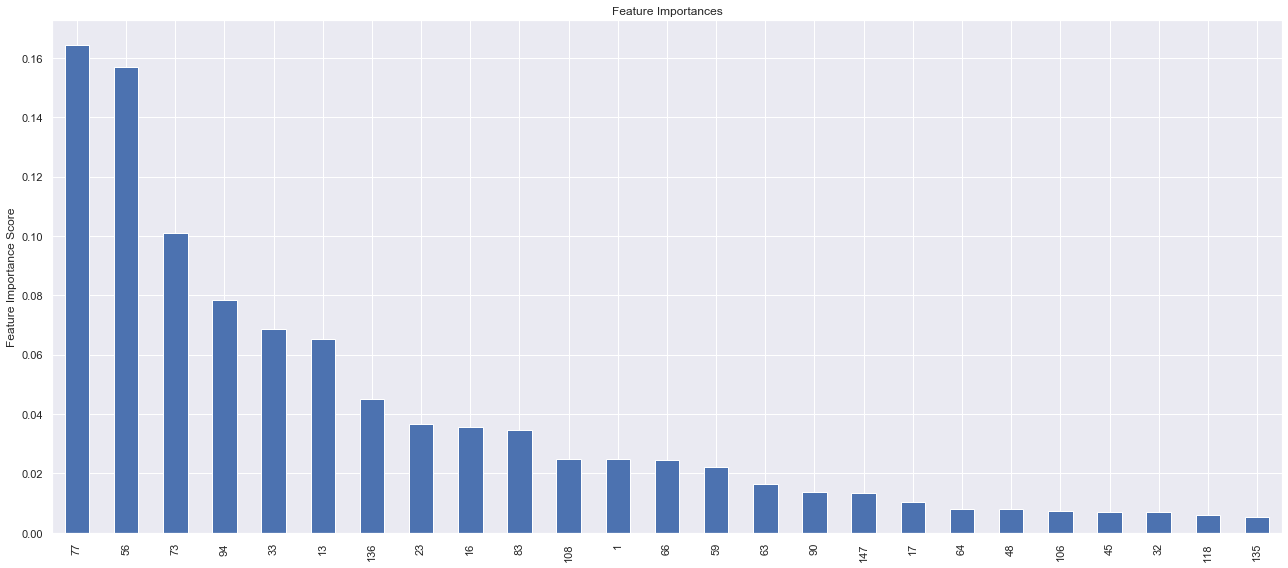

In [39]:
%%time

# Criando o modelo XGB com todas as otimizações
modeloXGB = XGBClassifier(learning_rate = 0.1, 
                          n_estimators = 10, 
                          max_depth = 4,
                          min_child_weight = 1, 
                          gamma = 0, 
                          subsample = 0.7, 
                          colsample_bytree = 0.6,
                          reg_alpha = 0.005,
                          objective = 'binary:logistic', 
                          n_jobs = -1,
                          scale_pos_weight = 1, 
                          seed = 42)

run_model_xgb(modeloXGB, train_x, train_y)

In [42]:
test_x = teste.drop(['ID'], axis=1)
submissionXGB = pd.read_csv('../dataset/sample_submission.csv')
submissionXGB['PredictedProb'] = modeloXGB.predict_proba(test_x)[:,1]
print(submissionXGB.shape)
submissionXGB.head()

ValueError: feature_names mismatch: ['v1', 'v10', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v11', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v12', 'v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v13', 'v130', 'v131', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v6', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v7', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v8', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v9', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'pca_1', 'ica_1', 'tsvd_1', 'grp_1', 'srp_1', 'pca_2', 'ica_2', 'tsvd_2', 'grp_2', 'srp_2', 'pca_3', 'ica_3', 'tsvd_3', 'grp_3', 'srp_3', 'pca_4', 'ica_4', 'tsvd_4', 'grp_4', 'srp_4'] ['target', 'v1', 'v10', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v11', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v12', 'v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v13', 'v130', 'v131', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v6', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v7', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v8', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v9', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'pca_1', 'ica_1', 'tsvd_1', 'grp_1', 'srp_1', 'pca_2', 'ica_2', 'tsvd_2', 'grp_2', 'srp_2', 'pca_3', 'ica_3', 'tsvd_3', 'grp_3', 'srp_3', 'pca_4', 'ica_4', 'tsvd_4', 'grp_4', 'srp_4']
training data did not have the following fields: target

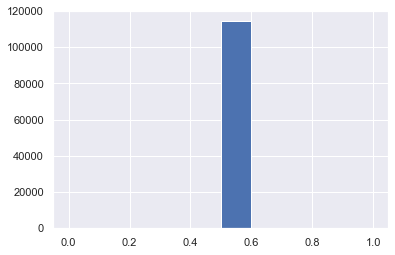

In [41]:
plt.hist(submissionXGB.PredictedProb)
plt.show()

# LightGBM

In [ ]:
# Configurações Gerais

STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_THREADS = 4
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [38]:
def run_model_lgb(data, categorical_feature = None):
    df   = data[data['target'].notnull()]
    test = data[data['target'].isnull()]
    
    del_features = ['target']
    predictors = list(filter(lambda v: v not in del_features, df.columns))
    
    print("Treino shape: {}, Teste shape: {}".format(df.shape, test.shape))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['target'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['target'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['target'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='logloss', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['binary_logloss']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['binary_logloss']

        print('Fold %2d Log Loss : %.6f' % (n_fold + 1, log_loss(valid_y, oof_preds[valid_idx])))
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full Log Loss score %.6f' % log_loss(df['target'], oof_preds)) 

    return sub_preds

In [ ]:
predLGB = run_model_lgb(df)

In [ ]:
submissionLGB = pd.read_csv('../dataset/sample_submission.csv')
submissionLGB['PredictedProb'] = predLGB
print(submissionLGB.shape)
submissionLGB.head()

# Ensemble Models

In [ ]:
submission = pd.DataFrame({'id': test_id})
submission['PredictedProb'] = submission1['PredictedProb'] * 0.85 + submission2['PredictedProb'] * 0.15
submission.to_csv('submission.csv', index=False)

# Submission

In [ ]:
new_test = df.loc[df['tipo'] == 1]
new_test = new_test.drop(['ID','target','tipo'], axis=1)
new_test.shape

In [ ]:
modeloXGB_v2.predict_proba(new_test)

In [ ]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = modeloXGB_v2.predict_proba(new_test)[:,1]
print(submission.shape)
submission.head()

In [ ]:
submission.to_csv('../submission/submission_xgb_v.1.1.2.csv', index=False)

In [ ]:
plt.hist(submission.PredictedProb)
plt.show()